In [41]:
!pip install pyspark
import pyspark
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

**ZAD1**

In [42]:
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

A = np.array([[0,1,1,0],[1,0,0,1],[1,0,0,1], [1,1,0,0]])

In [43]:
M = A / A.sum(axis = 0)
M

array([[0.        , 0.5       , 1.        , 0.        ],
       [0.33333333, 0.        , 0.        , 0.5       ],
       [0.33333333, 0.        , 0.        , 0.5       ],
       [0.33333333, 0.5       , 0.        , 0.        ]])

In [44]:
r = np.ones(M.shape[0]) / M.shape[0]
for _ in range(50):
  r = np.dot(M, r)
r

array([0.33333333, 0.22222222, 0.22222222, 0.22222222])

In [45]:
evc, evals = np.linalg.eig(M)
evals[:,1]

array([0.65465367, 0.43643578, 0.43643578, 0.43643578])

In [46]:
evals[:,1] / sum(evals[:,1])

array([0.33333333, 0.22222222, 0.22222222, 0.22222222])

In [47]:
evc, evals

(array([-0.5,  1. ,  0. , -0.5]),
 array([[-0.8660254 ,  0.65465367,  0.70710678,  0.8660254 ],
        [ 0.28867513,  0.43643578, -0.47140452, -0.28867513],
        [ 0.28867513,  0.43643578,  0.23570226, -0.28867513],
        [ 0.28867513,  0.43643578, -0.47140452, -0.28867513]]))

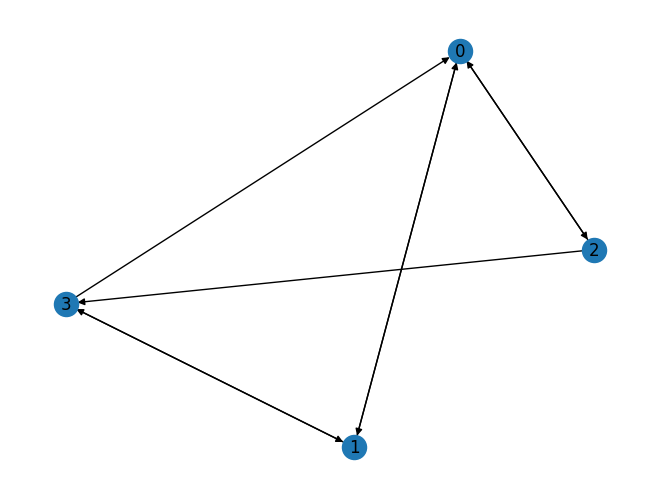

In [48]:
G = nx.from_numpy_array(A, create_using=nx.DiGraph)

nx.draw(G, with_labels=True)


In [49]:
nx.pagerank(G,alpha = 1)

{0: 0.3333333134651184,
 1: 0.2777782082557678,
 2: 0.1666666865348816,
 3: 0.22222179174423218}

In [50]:
r

array([0.33333333, 0.22222222, 0.22222222, 0.22222222])

**ZAD 2**

In [51]:
A = np.array([[0, 1, 1, 0],
              [1, 0, 0, 1],
              [1, 0, 0, 1],
              [1, 1, 0, 0]])

In [52]:
M = A / A.sum(axis=0)

beta = 0.8
n = M.shape[0]
e = np.ones(n) / n

r = np.ones(n) / n

for _ in range(50):
    r = beta * np.dot(M, r) + (1 - beta) * e

r

array([0.32142857, 0.22619048, 0.22619048, 0.22619048])

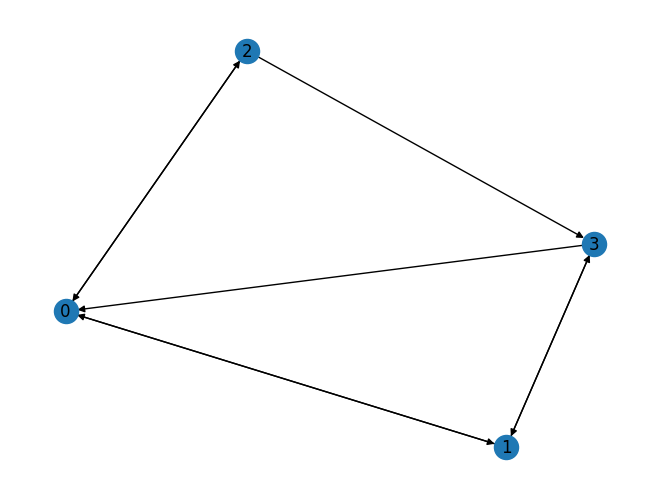

In [53]:
G = nx.from_numpy_array(A, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)
plt.show()

In [54]:
nx.pagerank(G,alpha = beta)

{0: 0.32142854075023364,
 1: 0.27040864535347203,
 2: 0.1785714592497664,
 3: 0.229591354646528}

In [55]:
r

array([0.32142857, 0.22619048, 0.22619048, 0.22619048])

**Zad3**

In [56]:
A = np.array([[0, 1, 1, 0],
              [1, 0, 0, 1],
              [1, 0, 0, 1],
              [1, 1, 0, 0]])
initial_ranks = np.array([1.0, 1.0, 1.0, 1.0])

In [57]:
def create_matrix_rdd(A, cluster_size):
    out = []
    for row in range(A.shape[0]):
        val = np.sum(A[row])
        for col in range(A.shape[1]):
            if A[row, col] == 1:
                out.append((row // cluster_size, (col, row, 1.0 / val)))
    return out

In [58]:
cluster_size = 2
matrix_rdd = sc.parallelize(create_matrix_rdd(A, cluster_size))
matrix_rdd.collect()

[(0, (1, 0, 0.5)),
 (0, (2, 0, 0.5)),
 (0, (0, 1, 0.5)),
 (0, (3, 1, 0.5)),
 (1, (0, 2, 0.5)),
 (1, (3, 2, 0.5)),
 (1, (0, 3, 0.5)),
 (1, (1, 3, 0.5))]

In [59]:
vector_rdd = sc.parallelize([(i, rank) for i, rank in enumerate(initial_ranks)])
vector_rdd.collect()

[(0, 1.0), (1, 1.0), (2, 1.0), (3, 1.0)]

In [40]:
beta = 0.8

for _ in range(50):
    vector_rdd = vector_rdd \
        .map(lambda p: (p[0] // cluster_size, (p[0], p[1]))) \
        .join(matrix_rdd) \
        .map(lambda r: (r[1][1][0], r[1][0][1] * r[1][1][2] if r[1][0][0] == r[1][1][1] else 0)) \
        .reduceByKey(lambda a, b: a + b) \
        .map(lambda p: (p[0], beta * p[1] + (1 - beta) / len(initial_ranks)))

print(vector_rdd.collectAsMap())

{0: 0.3214428439054985, 1: 0.2704200569960787, 2: 0.1785785648098921, 3: 0.2296013517193119}
